In [4]:
import socket
import numpy as np
import time
from matplotlib import pyplot as plt
#from mylibrary import SBAccess


#Help obtained with the command:
#python -c "import SBAccess ; help(SBAccess)"

import socket
from mylibrary import ByteUtil as bu


class SBAccess(object):
    
    """ A Class to Read Slide Book Format 7 Files """

    # All access functions as in SBReadFile.h

    def __init__(self, inSocket):
        self.mSocket = inSocket

    def SendCommand(self,inCommand):
        theBytes = bu.string_to_bytes(inCommand)
        self.mSocket.send(theBytes)

    def SendVal(self,inVal,inType):
        theBytes = bu.type_to_bytes(inVal,inType)
        self.mSocket.send(theBytes)

    def SendByteArray(self,inBytes):
        self.mSocket.send(inBytes)

    def RecvBigData(self,n):
        # Helper function to recv n bytes or return None if EOF is hit
        data = bytearray()
        while len(data) < n:
            packet = self.mSocket.recv(n - len(data))
            if not packet:
                return None
            data.extend(packet)
        return data

    def Recv(self):

        theRecvBuf = b''
        b = self.mSocket.recv(1)
        if b != b'&':
            raise Exception("First character in answer must be a: &")
        while True:
            b = self.mSocket.recv(1)
            if b == b'(':
                continue
            if b == b')':
                break;

            theRecvBuf += bytes(b)
        # parse the string
        str = bu.bytes_to_string(theRecvBuf)
        #print("str is: ",str)
        #split in list of arguments
        largs = str.split(',')
        #receive all the largs
        if(len(largs) != 1):
            raise Exception("Can only receive n values of same type")
        arg = largs[0]

        #split is size and format
        prop = arg.split(":")
        if(len(prop) != 2):
            raise Exception("Invalid argument format: " + str)
        theNum = int(prop[0])
        theType = prop[1]

        theSize = 1
        if (theType == 'i4' or theType == 'u4' or theType == 'f4'):
            theSize = 4
        elif (theType == 'i2' or theType == 'u2'):
            theSize = 2
        elif (theType == 'i8' or theType == 'u8' or theType == 'f8'):
            theSize = 8

        theValBuf = b''
        theValBuf =  self.RecvBigData(theNum * theSize)
        #print('theValBuf is: ',theValBuf)

        if(len(theValBuf) != theNum * theSize):
            raise Exception("Did not receive enough data")

        if theType == 's':
            theStr = bu.bytes_to_string(theValBuf)
            return theStr
        else:
            theArr = bu.bytes_to_type(theValBuf,theType)
            return theNum,theArr
        
    def Open(self,inPath):
        """Open a SlideBook file and loads the Metadata

        Parameters
        ----------
        inPath : str
            The path of the SlideBook file to open

        Returns
        -------
        int
            The Slide Id
        """
        l = len(inPath)
        self.SendCommand('$Open(FileName='+str(l)+':s)')
        self.SendVal(inPath,'s')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("OpenFile: colud not open path: "+inPath)
        return theVals[0]

    def GetCurrentSlideId(self):
        """returns the Slide Id of the active slide
        Returns
        -------
        int
            The Slide Id
        """
        self.SendCommand('$GetCurrentSlideId()')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetCurrentSlideId: error")
        return theVals[0]

    def SetTargetSlide(self,inSlideId):
        """Sets the target slide for subsequent operations 

        Parameters
        ----------
        int
            The Slide Id

        Returns
        -------
        int
            1 on success
        """

        self.SendCommand('$SetTargetSlide(SlideId=i4)')
        self.SendVal(int(inSlideId),'i4')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("SetTargetSlide: invalid value")
        if( theVals[0] != 1):
            raise Exception("SetTargetSlide: failed")

        return

    def CreateNewSlide(self):
        """Creates a new Slide

        Returns
        -------
        int
            The Slide Id
        """
        self.SendCommand('$CreateNewSlide()')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("CreateNewSlide: error")
        return theVals[0]


    def GetNumCaptures(self):
        """ Gets the number of captures (image groups) in the file

        Returns
        -------
        int
            The number of captures
        """

        self.SendCommand('$GetNumCaptures()')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetNumCaptures: invalid value")

        print("GetNumCaptures: ",theVals[0])

        return theVals[0]

    def GetNumLiveCaptures(self):
        """ Gets the number of live captures (image groups) in the file

        Returns
        -------
        int
            The number of live captures
        """

        self.SendCommand('$GetNumLiveCaptures()')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetNumLiveCaptures: invalid value")

        print("GetNumLiveCaptures: ",theVals[0])

        return theVals[0]



    def GetNumMasks(self,inCaptureIndex):
        """ Gets the number of masks in an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        int
            The number of masks
        """

        self.SendCommand('$GetNumMasks(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetNumMasks: invalid value")


        return theVals[0]

    def GetNumPositions(self,inCaptureIndex):
        """ Gets the number of (montage) positions in an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        int
            The number of positions
        """

        self.SendCommand('$GetNumPositions(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetNumPositions: invalid value")


        return theVals[0]

    def GetNumXColumns(self,inCaptureIndex):
        """ Gets the number of columns (width) of an image in an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        int
            The number of columns or width of the image
        """
        self.SendCommand('$GetNumXColumns(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetNumXColumns: invalid value")

        print("GetNumXColumns: ",theVals[0])

        return theVals[0]

    def GetNumYRows(self,inCaptureIndex):
        """ Gets the number of rows (height) of an image in an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        int
            The number of rows or height of the image
        """

        self.SendCommand('$GetNumYRows(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetNumYRows: invalid value")

        print("GetNumYRows: ",theVals[0])

        return theVals[0]
        


    def GetNumZPlanes(self,inCaptureIndex):
        """ Gets the number of z planes of an image in an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        int
            The number of z planes of the image
        """

        self.SendCommand('$GetNumZPlanes(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetNumZPlanes: invalid value")

        print("GetNumZPlanes: ",theVals[0])

        return theVals[0]


    def GetNumTimepoints(self,inCaptureIndex):
        """ Gets the number of time points in an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        int
            The number of time points
        """

        self.SendCommand('$GetNumTimepoints(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetNumTimepoints: invalid value")


        return theVals[0]


    def GetNumChannels(self,inCaptureIndex):
        """ Gets the number of channels in an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        int
            The number of channels
        """
        self.SendCommand('$GetNumChannels(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetNumChannels: invalid value")

        return theVals[0]

    def GetExposureTime(self,inCaptureIndex,inChannelIndex):
        """ Gets the exposure time in ms for a particular channel of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        inChannelIndex: int
            The index of the channel. Must be in range(0,number of channels)

        Returns
        -------
        int
            The exposure time in ms
        """
        self.SendCommand('$GetExposureTime(CaptureIndex=i4,ChannelIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetExposureTime: invalid value")

        return theVals[0]


    def GetVoxelSize(self,inCaptureIndex):
        """ Gets the voxel size in microns of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        float
            The X voxel size in um
        float
            The Y voxel size in um
        float
            The Z voxel size in um

        """
        self.SendCommand('$GetVoxelSize(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')

        theNum,theVoxelX = self.Recv()
        if( theNum != 1):
            raise Exception("GetVoxelSize: invalid value")

        theNum,theVoxelY = self.Recv()
        if( theNum != 1):
            raise Exception("GetVoxelSize: invalid value")

        theNum,theVoxelZ = self.Recv()
        if( theNum != 1):
            raise Exception("GetVoxelSize: invalid value")

        return theVoxelX,theVoxelY,theVoxelZ


    def GetXPosition(self,inCaptureIndex,inPositionIndex):
        """ Gets the X position in microns of the center of an image of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inPositionIndex: int
            The index of the image in the montage, or 0 if all images are at the same location

        Returns
        -------
        float
            The X position in um
        """
        self.SendCommand('$GetXPosition(CaptureIndex=i4,PositionIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inPositionIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetXPosition: invalid value")

        return theVals[0]

    def GetYPosition(self,inCaptureIndex,inPositionIndex):
        """ Gets the Y position in microns of the center of an image of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inPositionIndex: int
            The index of the image in the montage, or 0 if all images are at the same location

        Returns
        -------
        float
            The Y position in um
        """
        self.SendCommand('$GetYPosition(CaptureIndex=i4,PositionIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inPositionIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetYPosition: invalid value")

        return theVals[0]



    def GetZPosition(self,inCaptureIndex,inPositionIndex,inZPlaneIndex):
        """ Gets the Z position in microns of the center of an image of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inPositionIndex: int
            The index of the image in the montage, or 0 if all images are at the same location

        Returns
        -------
        float
            The Z position in um
        """
        self.SendCommand('$GetZPosition(CaptureIndex=i4,PositionIndex=i4,ZPlaneIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inPositionIndex),'i4')
        self.SendVal(int(inZPlaneIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetZPosition: invalid value")

        return theVals[0]



    def GetMontageRow(self,inCaptureIndex,inPositionIndex):
        """ Gets the rows of the montage at a given position in an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inPositionIndex: int
            The position of an image whose row is to be retrieved

        Returns
        -------
        int
            The row number (first row is 0)
        """
        self.SendCommand('$GetMontageRow(CaptureIndex=i4,PositionIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inPositionIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetMontageRow: invalid value")

        return theVals[0]

    def GetMontageColumn(self,inCaptureIndex,inPositionIndex):
        """ Gets the number of columns of the montage at a given position in an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inPositionIndex: int
            The position of an image whose column is to be retrieved

        Returns
        -------
        int
            The column number (first column is 0) 
        """
        self.SendCommand('$GetMontageColumn(CaptureIndex=i4,PositionIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inPositionIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetMontageColumn: invalid value")

        return theVals[0]

    def GetElapsedTime(self,inCaptureIndex,inTimepointIndex):
        """ Gets the elapsed time in ms at a given time point in an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inTimepointIndex: int
            The time point number

        Returns
        -------
        int
            The elapsed time in ms
        """
        self.SendCommand('$GetElapsedTime(CaptureIndex=i4,TimepointIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inTimepointIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetElapsedTime: invalid value")

        return theVals[0]



    def GetChannelName(self,inCaptureIndex,inChannelIndex):
        """ Gets the name of a given channel of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        inChannelIndex: int
            The index of the channel. Must be in range(0,number of channels)

        Returns
        -------
        str
            The name of the channel
        """
        self.SendCommand('$GetChannelName(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')

        theStr = self.Recv()
        return theStr

    def GetLensName(self,inCaptureIndex):
        """ Gets the name of the lens of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        str
            The name of the lens
        """
        self.SendCommand('$GetLensName(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')

        theStr = self.Recv()
        return theStr

    def GetMagnification(self,inCaptureIndex):
        """ Gets the magnification of the lens of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        float
            The magnification of the lens
        """
        self.SendCommand('$GetMagnification(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetMagnification: invalid value")

        return theVals[0]


    def GetImageName(self,inCaptureIndex):
        """ Gets the name of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        str
            The name of the image group
        """

        self.SendCommand('$GetImageName(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')

        theStr = self.Recv()
        return theStr

    def GetMaskName(self,inCaptureIndex,inMaskIndex):
        """ Gets the name of a mask

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        inMaskIndex: int
            The index of the mask. Must be in range(0,number of masks)

        Returns
        -------
        str
            The name of the mask
        """

        self.SendCommand('$GetMaskName(CaptureIndex=i4,MaskIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inMaskIndex),'i4')

        theStr = self.Recv()
        return theStr

    def GetImageComment(self,inCaptureIndex):
        """ Gets the comments of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        str
            The comments of the image group
        """
        self.SendCommand('$GetImageComment(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')

        theStr = self.Recv()
        return theStr

    def GetCaptureDate(self,inCaptureIndex):
        """ Gets the date of acquisition of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)

        Returns
        -------
        str
            date is inhe format: yyyy:MM:dd:hh:mm:ss
        """
        self.SendCommand('$GetCaptureDate(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')

        theStr = self.Recv()
        return theStr



    def ReadImagePlaneBuf(self,inCaptureIndex,inPositionIndex,inTimepointIndex,inZPlaneIndex,inChannelIndex):
        """ Reads a z plane of an image into a numpy array

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inPositionIndex: int
            The position of the image. If the image group is not a montage, use 0
        inTimepointIndex: int
            The time point
        inZPlaneIndex: int
            The z plane number
        inChannelIndex: int
            The channel number

        Returns
        -------
        numpy uint16 array 
            The image is returned as 1D numpy uint16 array

        """
        self.SendCommand('$ReadImagePlaneBuf(CaptureIndex=i4,PositionIndex=i4,TimepointIndex=i4,ZPlaneIndex=i4,ChannelIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inPositionIndex),'i4')
        self.SendVal(int(inTimepointIndex),'i4')
        self.SendVal(int(inZPlaneIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')

        theNum,theVals = self.Recv()
        return theVals

    def GetAuxDataXMLDescriptor(self,inCaptureIndex,inChannelIndex):
        """ Gets the Auxiliary Data XML Descriptor for an image group and a channel
        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inChannelIndex: int
            The channel number

        Returns
        -------
        str
            The XML Descriptor
        """
        self.SendCommand('$GetAuxDataXMLDescriptor(CaptureIndex=i4,ChannelIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')

        theStr = self.Recv()
        return theStr


    def GetAuxDataNumElements(self,inCaptureIndex,inChannelIndex):
        """ Gets the Auxiliary Data number of elements for an image group and a channel
        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inChannelIndex: int
            The channel number

        Returns
        -------
        int
            The number of elements
        """
        self.SendCommand('$GetAuxDataNumElements(CaptureIndex=i4,ChannelIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetMagnification: invalid value")

        return theVals[0]


        

    def GetAuxFloatData(self,inCaptureIndex,inChannelIndex):
        """ Gets the Auxiliary Float Data for an image group and a channel
        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inChannelIndex: int
            The channel number

        Returns
        -------
        list : float
            The Float Data as a list
        """
        self.SendCommand('$GetAuxFloatData(CaptureIndex=i4,ChannelIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')

        theNum,theVals = self.Recv()
        return theVals


    def GetAuxDoubleData(self,inCaptureIndex,inChannelIndex):
        """ Gets the Auxiliary Double Data for an image group and a channel
        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inChannelIndex: int
            The channel number

        Returns
        -------
        list : float
            The Double Data as a list
        """
        self.SendCommand('$GetAuxDoubleData(CaptureIndex=i4,ChannelIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')

        theNum,theVals = self.Recv()
        return theVals



    def GetAuxSInt32Data(self,inCaptureIndex,inChannelIndex):
        """ Gets the Auxiliary Signed Int32 Data for an image group and a channel
        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inChannelIndex: int
            The channel number

        Returns
        -------
        list: int
            The Signed Int32 Data as a list
        """
        self.SendCommand('$GetAuxSInt32Data(CaptureIndex=i4,ChannelIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')

        theNum,theVals = self.Recv()
        return theVals


    def GetAuxSInt64Data(self,inCaptureIndex,inChannelIndex):
        """ Gets the Auxiliary Signed Int64 Data for an image group and a channel
        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inChannelIndex: int
            The channel number

        Returns
        -------
        list: int
            The Signed Int64 Data as a list
        """
        self.SendCommand('$GetAuxSInt64Data(CaptureIndex=i4,ChannelIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')

        theNum,theVals = self.Recv()
        return theVals


    def GetAuxSerializedData(self,inCaptureIndex,inChannelIndex,inElementIndex):
        """ Gets the Auxiliary XML Data for an image group and a channel
        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inChannelIndex: int
            The channel number

        Returns
        -------
        list: str
            The XML Data as a list
        """
        self.SendCommand('$GetAuxSerializedData(CaptureIndex=i4,ChannelIndex=i4,ElementIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')
        self.SendVal(int(inElementIndex),'i4')

        theStr = self.Recv()
        return theStr
        
    def CreateImageGroup(self,inImageName,inNumChannels,inNumPlanes,inNumRows,inNumColumns,inNumTimepoints):
        """ creates a new image in the current slide

        Parameters
        ----------
        inImageName:    str
            The name of the image
        inNumChannels: int
            The number of channels in the image. Must be in the range(1,8)
        inNumPlanes: int
            The number of planes in the image (numZ). Must be in the range(1,65535)
        inNumRows: int
            The number of rows in the image (numY). Must be in the range(2,2^11)
        inNumColumns: int
            The number of columns in the image (numX). Must be in the range(2,2^11)
        inNumTimepoints: int
            The number of timepoints in the image (numT). Must be in the range(1,2^11)

        Returns
        -------
        int
            The index of the image group.
        """
        l = len(inImageName)

        self.SendCommand('$CreateImageGroup(ImageName='+str(l)+':s,NumChannels=i4,NumPlanes=i4,NumRows=i4,NumColumns=i4,NumTimepoints=i4)')
        self.SendVal(inImageName,'s')
        self.SendVal(int(inNumChannels),'i4')
        self.SendVal(int(inNumPlanes),'i4')
        self.SendVal(int(inNumRows),'i4')
        self.SendVal(int(inNumColumns),'i4')
        self.SendVal(int(inNumTimepoints),'i4')

        theNum,theVals = self.Recv()
        return theVals

    def CopyImageGroup(self,inCopyCaptureIndex):
        """ Copy an image group from another one

        Parameters
        ----------
        inCopyCaptureIndex: int
            The index of the source image group. Must be in range(0,number of captures)
        Returns
        -------
        none
        """
        self.SendCommand('$CopyImageGroup(CopyCaptureIndex=i4)')
        self.SendVal(int(inCopyCaptureIndex),'i4')
        theNum,theVals = self.Recv()
        return theVals

    def SetImageComment(self,inCaptureIndex,inComment):

        """ Sets the comment (info) of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inComment:    str
            The comments of the image

        Returns
        -------
        none
        """
        l = len(inComment)
        self.SendCommand('$SetImageComment(CaptureIndex=i4,Comment='+str(l)+':s)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(inComment,'s')


    def SetChannelName(self,inCaptureIndex,inChannelIndex,inChannelName):
        """ Sets the name of an channel

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inChannelIndex: int
            The index of the channel in range(0,NumChannels-1)
        inChannelName:  str
            The name of the channel

        Returns
        -------
        none
        """
        l = len(inChannelName)
        self.SendCommand('$SetChannelName(CaptureIndex=i4,ChannelIndex=i4,ChannelName='+str(l)+':s)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(ChannelIndex),'i4')
        self.SendVal(inChannelName,'s')


    def SetMagnification(self,inCaptureIndex,inLensMagnification,inOptovarMagnification):
        """ Sets the Magnification of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inMagnification: float
            The inMagnification of the image

        Returns
        -------
        none
        """
        
        self.SendCommand('$SetMagnification(CaptureIndex=i4,LensMagnification=f4,OptovarMagnification=f4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(float(inLensMagnification),'f4')
        self.SendVal(float(inOptovarMagnification),'f4')

    def SetVoxelSize(self,inSizeX,inSizeY,inSizeZ):
        """ Sets the voxel size in microns of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inSizeX: float
            The X voxel size in um
        inSizeY: float
            The Y voxel size in um
        inSizeZ: float
            The Z voxel size in um

        Returns
        -------
        none
        """
        
        self.SendCommand('$SerVoxelSize(CaptureIndex=i4,SizeX=f4,SizeY=f4,SizeZ=f4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(float(inSizeX),'f4')
        self.SendVal(float(inSizeY),'f4')
        self.SendVal(float(inSizeZ),'f4')

    def SetCaptureDate(self,inCaptureIndex,inYear,inMonth,inDay,inHour,inMinute,inSecond):
        """ Sets the date of acquisition of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inDateStr: str
            date is in the format: yyyy:MM:dd:hh:mm:ss

        Returns
        -------
        none
        """
        self.SendCommand('$SetCaptureDate(CaptureIndex=i4,Year=i4,Month=i4,Day=i4,Hour=i4,Minute=i4,Second=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inYear),'i4')
        self.SendVal(int(inMonth),'i4')
        self.SendVal(int(inDay),'i4')
        self.SendVal(int(inHour),'i4')
        self.SendVal(int(inMinute),'i4')
        self.SendVal(int(inSecond),'i4')
        
    def SetXYZPosition(self,inCaptureIndex,inPositionX,inPositionY,inPositionZ):
        """ Sets the x,y,z position of an image group

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inPositionX: float
            The X Position
        inPositionY: float
            The Y Position
        inPositionZ: float
            The Z Position

        Returns
        -------
        none
        """
        self.SendCommand('$SetXYZPosition(CaptureIndex=i4,PositionX=f4,PositionY=f4,PositionZ=f4)')
        self.SendVal(float(inPositionX),'f4')
        self.SendVal(float(inPositionY),'f4')
        self.SendVal(float(inPositionZ),'f4')

    def WriteImagePlaneBuf(self,inCaptureIndex,inTimepointIndex,inZPlaneIndex,inChannelIndex,inNumpyArray):
        """ Writes a z plane of an image from a numpy array

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inTimepointIndex: int
            The time point
        inZPlaneIndex: int
            The z plane number
        inChannelIndex: int
            The channel number. If the channel number (they start at 0) is equal to the number of channels, then a new channel is added
        inNumpyArray: numpy array of u2 (unsigned 16 bit integer)
            The data buffer for the plane to be written

        Returns
        -------
        none
        """
        theBytes = inNumpyArray.tobytes()
        l = len(theBytes)

        self.SendCommand('$WriteImagePlaneBuf(CaptureIndex=i4,TimepointIndex=i4,ZPlaneIndex=i4,ChannelIndex=i4,ByteArray='+str(l)+':b)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inTimepointIndex),'i4')
        self.SendVal(int(inZPlaneIndex),'i4')
        self.SendVal(int(inChannelIndex),'i4')
        self.SendByteArray(theBytes);

        theNum,theVals = self.Recv()
        if( theNum != 1 and theVals[0] != 1):
            raise Exception("WriteImagePlaneBuf: error")
    
    # Mask fucntions

    def ReadMaskPlaneBuf(self,inCaptureIndex,inMaskIndex,inTimepointIndex,inZPlaneIndex):
        """ Reads a z plane of a mask into a numpy array

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inMaskIndex: int
            The nindex of the mask
        inTimepointIndex: int
            The time point
        inZPlaneIndex: int
            The z plane number
        Returns
        -------
        numpy uint16 array 
            The mask is returned as 1D numpy uint16 array

        """

        self.SendCommand('$ReadMaskPlaneBuf(CaptureIndex=i4,MaskIndex=i4,TimepointIndex=i4,ZPlaneIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(int(inMaskIndex),'i4')
        self.SendVal(int(inTimepointIndex),'i4')
        self.SendVal(int(inZPlaneIndex),'i4')

        theNum,theVals = self.Recv()
        return theVals


    def WriteMaskPlaneBuf(self,inCaptureIndex,inMaskName,inTimepointIndex,inZPlaneIndex,inNumpyArray):
        """ Writes a z plane of a mask from a numpy array

        Parameters
        ----------
        inCaptureIndex: int
            The index of the image group. Must be in range(0,number of captures)
        inMaskName: str
            The name of the mask
        inTimepointIndex: int
            The time point
        inZPlaneIndex: int
            The z plane number
        inNumpyArray: numpy array of u2 (unsigned 16 bit integer)

        Returns
        -------
        none
        """
        theBytes = inNumpyArray.tobytes()
        lb = len(theBytes)
        lm = len(inMaskName)

        self.SendCommand('$WriteMaskPlaneBuf(CaptureIndex=i4,MaskName='+str(lm)+':s,TimepointIndex=i4,ZPlaneIndex=i4,ByteArray='+str(lb)+':b)')
        self.SendVal(int(inCaptureIndex),'i4')
        self.SendVal(inMaskName,'s')
        self.SendVal(int(inTimepointIndex),'i4')
        self.SendVal(int(inZPlaneIndex),'i4')
        self.SendByteArray(theBytes);

        theNum,theVals = self.Recv()
        if( theNum != 1 and theVals[0] != 1):
            raise Exception("WriteMaskPlaneBuf: error")


    # Live capture functions

    def StartCapture(self,inScriptName='Default'):
        """ Starts a capture with an optional script name
        Parameters
        ----------
        inScriptName: int
            The script name to load before starting the capture. If blank, the Default script  is loaded

        Returns
        -------
        int
            the capture id. If the capture failed to start, return -1
        """
        l = len(inScriptName)
        self.SendCommand('$StartCapture(ScriptName='+str(l)+':s)')
        self.SendVal(inScriptName,'s')
        theNum,theVals = self.Recv()
        if( theNum != 1 or theVals[0] == -1):
            raise Exception("WriteMaskPlaneBuf: error")

        return theVals[0]

    def GetCurrentCaptureId(self,inPositionIndex):
        """ Gets the id of the capture which is currently taking place.

        Parameters
        ----------
        inPositionIndex: int
            The index of the montage position. For non montage capture, use 0

        Returns
        -------
        int
            the capture id
        """
        self.SendCommand('$GetCurrentCaptureId(PositionIndex=i4)')
        self.SendVal(int(inPositionIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetCurrentCaptureId: invalid value")

        return theVals[0]

    def GetLastImageCaptured(self,inCaptureIndex):
        """ Gets the index of the last image captured

        Parameters
        ----------
        inCaptureIndex: int
            The index of the capture

        Returns
        -------
        int
            the index (timepoint) of the last image captured
        """

        self.SendCommand('$GetLastImageCaptured(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetLastImageCaptured: invalid value")

        return theVals[0]

    def GetLastPlaneCaptured(self,inCaptureIndex):
        """ Gets the index of the last plane captured

        Parameters
        ----------
        inCaptureIndex: int
            The index of the capture

        Returns
        -------
        int
            the index (plane) of the last plane captured
        """

        self.SendCommand('$GetLastPlaneCaptured(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetLastPlaneCaptured: invalid value")

        return theVals[0]

    def GetLastChannelCaptured(self,inCaptureIndex):
        """ Gets the index of the last Channel captured

        Parameters
        ----------
        inCaptureIndex: int
            The index of the capture

        Returns
        -------
        int
            the index (plane) of the last plane captured
        """

        self.SendCommand('$GetLastChannelCaptured(CaptureIndex=i4)')
        self.SendVal(int(inCaptureIndex),'i4')

        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("GetLastChannelCaptured: invalid value")

        return theVals[0]

    def IsCapturing(self):
        """ Checks if there is an active capture

        Parameters
        ----------

        Returns
        -------
        bool
            True if is capturing, false if it is not
        """
        self.SendCommand('$IsCapturing()')
        theNum,theVals = self.Recv()
        if( theNum != 1):
            raise Exception("IsCapturing: failed")
        if(theVals[0] > 0):
            return True
        else:
            return False




#HOST = '127.0.0.1'  # Standard loopback interface address (localhost)
#HOST = '192.168.56.101'  # Standard loopback interface address (localhost)
PORT = 65432        # Port to listen on (non-privileged ports are > 1023)




In [5]:
def get_array(capture_number, channel):
    HOST = '127.0.0.1'  # The server's hostname or IP address

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        theSbAccess = SBAccess(s)
        theInpSlideId = theSbAccess.GetCurrentSlideId();

        theInpCaptureIndex = capture_number;
        theNumRows = theSbAccess.GetNumYRows(theInpCaptureIndex)
        theNumColumns = theSbAccess.GetNumXColumns(theInpCaptureIndex)
        theNumPlanes = theSbAccess.GetNumZPlanes(theInpCaptureIndex)
        theNumChannels = theSbAccess.GetNumChannels(theInpCaptureIndex)
        
        hold=[]
        for theZPlane in range(theNumPlanes):          
            theSbAccess.SetTargetSlide(theInpSlideId)
            image = theSbAccess.ReadImagePlaneBuf(theInpCaptureIndex,0,0,theZPlane,channel) #captureid,position,timepoint,zplane,channel
            image=image.reshape(theNumRows,theNumColumns)
            hold.append(image)
        hold=np.array(hold)
        #outputs to z,x,y in sldbk ordering
    return hold


In [62]:
im=get_array(1, 1)
np.shape(im)

GetNumYRows:  400
GetNumXColumns:  400
GetNumZPlanes:  30


(30, 400, 400)

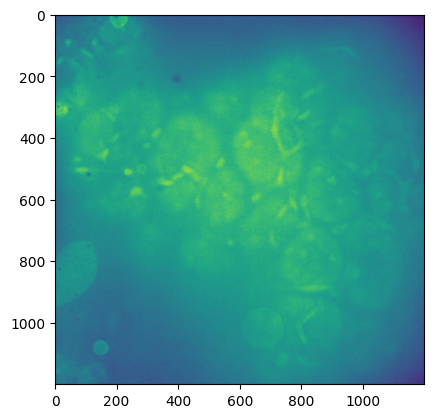

In [9]:
import matplotlib.pyplot as plt
plt.imshow(im[10,:,:])

In [79]:
im.dtype
im1=im/np.max(im)
im1.dtype

dtype('float64')

In [11]:
from stardist.models import StarDist3D
from skimage import img_as_float

In [64]:
model = StarDist3D.from_pretrained('3D_demo')
prob_thresh = 0.3 # Example probability threshold
nms_thresh = 0.6   # Example non-maximum suppression threshold
im_sm = img_as_float(im)
# Predict instances in the 3D image with custom thresholds
labels, details = model.predict_instances(im_sm, prob_thresh=prob_thresh, nms_thresh=nms_thresh)


Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.


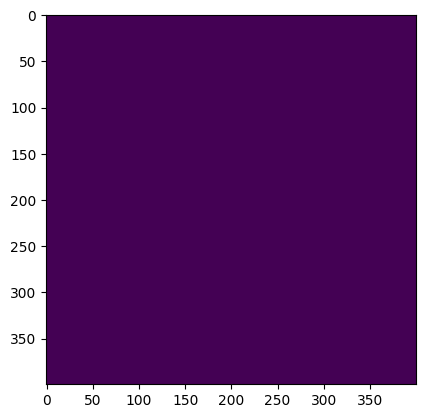

In [68]:
plt.imshow(labels[7,:,:])

In [75]:
def test_export_dl_result(index_number,channel, model_dim, prob_thres,nms_thres, mask_name):
    HOST = '127.0.0.1'  # The server's hostname or IP address

    image=get_array(index_number,channel)
    # Convert to float
    image=image/np.max(image)
    image = img_as_float(image)

    # Load a pre-trained StarDist3D model
    if model_dim=="2D":
        model=StarDist2D.from_pretrained('2D_versatile_fluo') 
    elif model_dim=="3D":
        model =StarDist3D.from_pretrained('3D_demo')

    prob_thresh = prob_thres  
    nms_thresh = nms_thres   

    labels,_= model.predict_instances(image, prob_thresh=prob_thresh, nms_thresh=nms_thresh)
    labels_16 = labels.astype(np.uint16)
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        theSbAccess = SBAccess(s)
        theInpSlideId = theSbAccess.GetCurrentSlideId()
        theNumPlanes = theSbAccess.GetNumZPlanes(index_number)

        for theZPlane in range(0,theNumPlanes,1):
            slice1 = labels_16[theZPlane, :, :]
            theSbAccess.WriteMaskPlaneBuf(index_number,mask_name,0,theZPlane,slice1)
    return 

In [77]:
test_export_dl_result(0,0, "3D", .6,.5,"Test4")

GetNumYRows:  763
GetNumXColumns:  648
GetNumZPlanes:  60
Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.
GetNumZPlanes:  60
